# <center>NLP: User experience multilabel classification</center>
---

##  Решение 2:
Очистка датасета от всех объектов со всеми отрицательными классами поможет модели в классификации, т.к., исходя из описания классов, хотя бы один из них должен быть положительным, следовательно датасет недоразмечен.

### План работы.
- Модели:
  - Для более глубокого понимания датасета моделью и из-за сравнительно небольшого кол-ва размеченных классов, обучим на очищенных данных нейросеть со смешаным входом.
- Данные:
  - для текстовых данных возьмём большую русскоязычную модель `ai-forever/ruRoberta-large`;
  - тэги закодируем как бинарные признаки;
  - оценки оставим без изменений.
- Результат:<br>
Решение не сработало. Нейросеть требует больше времени на доработку и эксперименты с включением тэгов/оценок в текст и пр.<br>

### Данные
- `train.csv.zip` - обучающая выборка;

|Название столбца|Описание столбца|
|:-|:-|
|index|Id объекта|
|assessment|Числовая оценка заказа(ов)|
|tags|Тематические теги|
|text|Текстовый коментарий|
|trend_id_res$X$|Код класса: $X ∈ [1, 50]$|

- `test.csv.zip` - тестовая выборка: аналогична обучающей, но без классов;
- `trend_description` - описание классов;
- `baseline.ipynb` - бейзлайн (`TfIdf` и логит. регрессия);
- `sample_submission.csv.zip` - пример посылки;
- `NLP User experience multilabel classification.docx` - ТЗ.

## Загрузка библиотек.
---

In [3]:
## os для обращения к среде разработки.
import os, sys

## Работа с датафреймами и датасетами.
import pandas as pd
## Визуализация.
import matplotlib.pyplot as plt
from matplotlib import rc
## numpy для вычислений.
import numpy as np, random

## Модели и модули.
from sklearn.model_selection import train_test_split
# !pip install torch --index-url https://download.pytorch.org/whl/cu118 -q
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
# Получение предобученных моделей и модулей.
# from sentence_transformers import SentenceTransformer
from transformers import (RobertaModel, AdamW, RobertaTokenizer,
                          RobertaForSequenceClassification)

## Дополнительные модули.
# tqdm для контроля выполнения ячеек.
from tqdm.notebook import tqdm, trange
# multiprocessing для оценки кол-ва доступных потоков.
from multiprocessing import cpu_count
# Кастомизация вывода.
from IPython.display import HTML
# Аннотация типов.
from typing import Optional, List, Union
# Подавление предупреждений.
import warnings
from transformers.utils import logging

## Установка параметров проекта.
---

### Установка пути к данным.

In [ ]:
# Зададим путь и название датасета.
PATH = None # Задайте путь к данным
TRAIN = 'train.csv.zip'
TEST = 'test.csv.zip'
TRENDS = 'trends_description.csv'

if not PATH:
    if 'google.colab' in sys.modules:
        env = 'colab'
        from google.colab import drive
        drive.mount('/content/drive')
        PATH = ('/content/drive/Othercomputers/PC/JupiterNB/Yandex_Practicum_'+
                'Workshop/NLP_Multilabel_Samokat/')
    elif 'KAGGLE_KERNEL_RUN_TYPE' in os.environ:
        env = 'kaggle'
        PATH = '/kaggle/input/ya-workshop-samokat-2025/'
        TRAIN = 'train.csv'
        TEST = 'test.csv'
        TRENDS = 'trends_description.csv'
    elif 'ipykernel' in sys.modules:
        env = 'local'
        PATH = ''

Mounted at /content/drive


### Инициализация генераторов случайных чисел.

In [ ]:
# Установим начальное значение генератора псевдослучайных чисел.
SEED = 42

def set_rnd_state(seed : int) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f'Случайные числа инициализированы с начальным значением {seed}.')

set_rnd_state(SEED)

Случайные числа инициализированы с начальным значением 42.


### Установка рабочего процессора.

In [ ]:
# Маркер доступноcти GPU.
if torch.cuda.is_available():
    # Определим кол-во доступных GPU.
    DEVICE = "cuda"
    DEVICE_COUNT = torch.cuda.device_count()
else:
    # Определим кол-во доступных потоков CPU.
    DEVICE = 'cpu'
    DEVICE_COUNT = cpu_count()
print(f'Работа на {DEVICE}. Кол-во: {DEVICE_COUNT}')

Работа на cuda. Кол-во: 1


### Установка других параметров.

In [ ]:
# Подавление предупреждений.
warnings.filterwarnings('ignore')
logging.set_verbosity_error()

# Зададим функцию вывода центрированного текста.
def print_h(text : str, *args, **kwargs) -> None:
    display(HTML('<div style="text-align:center; font-weight:bold; '+
                 f'font-size:20px">{text}</div>'))
# Зададим функцию вывода жирного текста.
def print_b(text : str, *args, **kwargs) -> None:
    print(f'\033[1m{text}\033[0m', *args, **kwargs)

# Функция вывода семпла датафрейма в стиле.
def display_s(df : pd.DataFrame | pd.Series,
              name : str = 'Датафрейм') -> None:
    if type(df) == pd.Series:
        df = df.to_frame()
    if df.shape[1] <= 3:
        df = df.T
    display(df.style.set_caption(name).set_table_styles(styles))

# Установим параметры отображения таблиц.
for opt in ['max_columns', 'max_rows', 'min_rows']:
    pd.set_option(f'display.{opt}', 1000)
pd.set_option('display.max_colwidth', None)

# Установим стиль отображения заголовков таблиц.
styles = [
    dict(selector = 'caption',
         props = [('text-align', 'center'),
                  ('font-size', '130%'),
                  ('font-weight', 'bold'),
                  ('white-space', 'pre-wrap')]),
    dict(selector = 'th',
         props = [('max-width', '250px')])
    ]

# Инициализуруем прогресс бар.
tqdm.pandas(desc="Идёт обработка:")

# Установим параметры отображения графиков.
MPL_WIDTH = 15
MPL_HEIGHT = 5
rc('font', size = 14)
figure_kwargs = dict(figsize = (MPL_WIDTH, MPL_HEIGHT),
                     facecolor = 'white',
                     autolayout = True,
                     titlesize = 16)
plt.style.use('seaborn-v0_8-whitegrid')
rc('figure', **figure_kwargs)

## Загрузка данных.
---

In [ ]:
data = pd.read_csv(os.path.join(PATH, TRAIN))
test_unk = pd.read_csv(os.path.join(PATH, TEST))
trends = pd.read_csv(os.path.join(PATH + TRENDS))

## Предобработка.



- Удалим объекты с пропущенными категориями и оценками.

In [ ]:
data.dropna(inplace=True)
print(f'Пропусков после удаления: {data.isna().sum().sum()}')

Пропусков после удаления: 0


- Создадим бинарные признаки из тэгов, содердашихся в признаке `tags` .
- Переведём и отформатируем признак `tags`.

In [ ]:
tags_rus = {
    'PROMOTIONS' : 'ПРОМОАКЦИИ',
    'DELIVERY' : 'ДОСТАВКА',
    'ASSORTMENT' : 'АССОРТИМЕНТ',
    'PRICE' : 'ЦЕНА',
    'PRODUCTS_QUALITY' : 'КАЧЕСТВО',
    'SUPPORT' : 'ПОДДЕРЖКА',
    'CATALOG_NAVIGATION' : 'ПРИЛОЖЕНИЕ',
    'PAYMENT' : 'ПЛАТЕЖИ'
}

def make_binaries_from_multicat_col(data : pd.DataFrame = None,
                                    col : str = None) -> pd.DataFrame:
    data['_list'] = (data[col]
                     .str.replace(r'{|}', '', regex=True)
                     .str.split(','))
    tags_unique = set(data['_list'].dropna().explode().tolist())
    data.drop('_list', axis=1, inplace=True)

    data[[x for x in tags_unique]] = np.zeros(
        (data.shape[0], len(tags_unique))
        )

    for tag in tags_unique:
        data[tag] = data[tag].where(~(data['tags'].str.contains(tag)), 1)

    data.columns = [x.lower() for x in data.columns]

    return data

def translate_multicat_col(data : pd.Series = None,
                           translation : dict = None) -> pd.Series:
    data = (
        data
        .replace(translation, regex=True)
        .str.replace(',', ', ')
        .str.replace(r'{|}', '', regex=True)
        )

    data = 'Категории: ' + data

    return data

def assessment_to_str(data : pd.Series) -> pd.Series:
    data = 'Оценка: ' + data.astype(int).astype(str)

    return data

In [ ]:
data = make_binaries_from_multicat_col(data, 'tags')
data['tags_rus'] = translate_multicat_col(data['tags'], tags_rus)
data['assessment_rus'] = assessment_to_str(data['assessment'])
data.head()

,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,trend_id_res9,trend_id_res10,trend_id_res11,trend_id_res12,trend_id_res13,trend_id_res14,trend_id_res15,trend_id_res16,trend_id_res17,trend_id_res18,trend_id_res19,trend_id_res20,trend_id_res21,trend_id_res22,trend_id_res23,trend_id_res24,trend_id_res25,trend_id_res26,trend_id_res27,trend_id_res28,trend_id_res29,trend_id_res30,trend_id_res31,trend_id_res32,trend_id_res33,trend_id_res34,trend_id_res35,trend_id_res36,trend_id_res37,trend_id_res38,trend_id_res39,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49,catalog_navigation,payment,price,support,assortment,products_quality,delivery,promotions,tags_rus,assessment_rus
0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,"Категории: АССОРТИМЕНТ, ПРОМОАКЦИИ, ДОСТАВКА",Оценка: 6
1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,"Категории: АССОРТИМЕНТ, ЦЕНА, КАЧЕСТВО, ДОСТАВКА",Оценка: 4
2,13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,"Категории: ДОСТАВКА, ПРОМОАКЦИИ, ЦЕНА, АССОРТИМЕНТ, ПОДДЕРЖКА",Оценка: 6
3,25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,"Категории: ЦЕНА, ПРОМОАКЦИИ, АССОРТИМЕНТ",Оценка: 6
4,15237,5.0,"{ASSORTMENT,PRODUCTS_QUALITY,PROMOTIONS,CATALOG_NAVIGATION}",Доставка просто 👍,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,"Категории: АССОРТИМЕНТ, КАЧЕСТВО, ПРОМОАКЦИИ, ПРИЛОЖЕНИЕ",Оценка: 5


- Создадим копию датасета, очищенную от объектов со всеми отрицательными классами.

In [ ]:
data_clean = data.copy()
data_clean = data_clean[
    (data_clean[[f'trend_id_res{i}' for i in range(0, 50)]] != 0).any(axis=1)
    ]
data_clean.info()
data_clean.head(2)

<class 'pandas.core.frame.DataFrame'>
Index: 4612 entries, 0 to 8707
Data columns (total 64 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   index               4612 non-null   int64  
 1   assessment          4612 non-null   float64
 2   tags                4612 non-null   object 
 3   text                4612 non-null   object 
 4   trend_id_res0       4612 non-null   int64  
 5   trend_id_res1       4612 non-null   int64  
 6   trend_id_res2       4612 non-null   int64  
 7   trend_id_res3       4612 non-null   int64  
 8   trend_id_res4       4612 non-null   int64  
 9   trend_id_res5       4612 non-null   int64  
 10  trend_id_res6       4612 non-null   int64  
 11  trend_id_res7       4612 non-null   int64  
 12  trend_id_res8       4612 non-null   int64  
 13  trend_id_res9       4612 non-null   int64  
 14  trend_id_res10      4612 non-null   int64  
 15  trend_id_res11      4612 non-null   int64  
 16  trend_id_re

,index,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,trend_id_res9,trend_id_res10,trend_id_res11,trend_id_res12,trend_id_res13,trend_id_res14,trend_id_res15,trend_id_res16,trend_id_res17,trend_id_res18,trend_id_res19,trend_id_res20,trend_id_res21,trend_id_res22,trend_id_res23,trend_id_res24,trend_id_res25,trend_id_res26,trend_id_res27,trend_id_res28,trend_id_res29,trend_id_res30,trend_id_res31,trend_id_res32,trend_id_res33,trend_id_res34,trend_id_res35,trend_id_res36,trend_id_res37,trend_id_res38,trend_id_res39,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49,catalog_navigation,payment,price,support,assortment,products_quality,delivery,promotions,tags_rus,assessment_rus
0,5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,"Категории: АССОРТИМЕНТ, ПРОМОАКЦИИ, ДОСТАВКА",Оценка: 6
1,18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,"Категории: АССОРТИМЕНТ, ЦЕНА, КАЧЕСТВО, ДОСТАВКА",Оценка: 4


## Разделение выборок.

### Функция разделения выборок.

In [ ]:
## Функция разделения на выборки с использованием train_test_split.
def tvt_strat_split(data : pd.DataFrame,
                    test_size : float = .2,
                    val_size : float = None,
                    stratify_by : str = None,
                    shuffle : bool = True,
                    show_results : bool = True,
                    seed : int = SEED):

    # Зададим значения генератора псевдосл. чисел.
    np.random.seed(seed)

    ## Разделим данные с помощью функции train_test_split из sklearn.
    # Разделение без валидационной выборки.
    if not val_size:
        train, test = train_test_split(
            data,
            test_size=test_size,
            shuffle=shuffle,
            random_state=SEED,
            stratify=data[stratify_by] if stratify_by else None
            )
        # Сбросим индексы выборок.
        for sample in [train, test]:
            sample.reset_index(drop=True, inplace=True)
        # Запись данных и индекса для таблицы проверки.
        size_check = [data, train, test]
        # balance_check = [data[target], y_train, y_test]
        index = ['Исходный датафрейм:', 'Обучающая выборка:',
                 'Тестовая выборка:']

    # Разделение с валидационной выборкой.
    else:
        # Первое разделение.
        X_t, val = train_test_split(
            data,
            test_size=val_size,
            shuffle=shuffle,
            random_state=SEED,
            stratify=data[stratify_by] if stratify_by else None
            )
        # Проверим признак для стратификации на соответствие целевому.
        if stratify_by:
            stratify_by_t = X_t[stratify_by] if stratify_by else None
        # Второе разделение.
        train, test = train_test_split(
            X_t,
            test_size=(1/(1-val_size)*test_size),
            shuffle=shuffle,
            random_state=SEED,
            stratify=stratify_by_t
            )

        # Сбросим индексы выборок.
        for sample in [train, val, test]:
            sample.reset_index(drop=True, inplace=True)

        # Запись данных и индекса для таблицы проверки.
        size_check = [data, train, val, test]
        # balance_check = [data[target], , y_val, y_test]
        index = ['Исходный датафрейм:', 'Обучающая выборка:',
                 'Валидационная выборка:', 'Тестовая выборка:']

    ## Выведем результаты при необходимости.
    if show_results:
        # Выведем таблицу проверки размерностей.
        balance_list = []
        for i in range(len(size_check)):
            balance_list.append(
                [size_check[i].shape[0],
                f'{(size_check[i].shape[0] / size_check[0].shape[0]):.1%}',
                size_check[i].shape[1]]
                )
        cols = ['Кол-во объектов.', 'Процент объектов.',
                'Кол-во признаков.']
        display(
            pd.DataFrame(balance_list, columns=cols,
                        index=index)
                .style
                .set_caption('Результат разделения выборок.')
                .set_table_styles(styles)
        )

    ## Выведем результирующие выборки.
    if val_size:
        return (train, val, test)
    else:

        return (train, test)

### Разделение выборок.

Разделим датасет `train` на обучающую, валидационную и тестовую выборки со стратификацией по оценкам `assessment`, т.к. они несбалансированы.

In [ ]:
train, val, test = tvt_strat_split(
    data = data_clean,
    test_size = .2,
    val_size = .2,
    stratify_by = 'assessment'
)

train_idx = train['index']
val_idx = val['index']
test_idx = test['index']

for df in [train, val, test]:
    df.drop('index', axis=1, inplace=True)
print('\n\n')
display_s(train.head(1), 'Первые строки обучающей выборки.')

,Кол-во объектов.,Процент объектов.,Кол-во признаков.
Исходный датафрейм:,4612,100.0%,64
Обучающая выборка:,2766,60.0%,64
Валидационная выборка:,923,20.0%,64
Тестовая выборка:,923,20.0%,64


,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,trend_id_res7,trend_id_res8,trend_id_res9,trend_id_res10,trend_id_res11,trend_id_res12,trend_id_res13,trend_id_res14,trend_id_res15,trend_id_res16,trend_id_res17,trend_id_res18,trend_id_res19,trend_id_res20,trend_id_res21,trend_id_res22,trend_id_res23,trend_id_res24,trend_id_res25,trend_id_res26,trend_id_res27,trend_id_res28,trend_id_res29,trend_id_res30,trend_id_res31,trend_id_res32,trend_id_res33,trend_id_res34,trend_id_res35,trend_id_res36,trend_id_res37,trend_id_res38,trend_id_res39,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49,catalog_navigation,payment,price,support,assortment,products_quality,delivery,promotions,tags_rus,assessment_rus
0,1.000000,"{PRODUCTS_QUALITY,PROMOTIONS,SUPPORT}","Последние разы привозили гнилые овощи, что было видно невооруженным глазом. В поддержке отвечают скриптами. Никакого уважения к клиенту",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,"Категории: КАЧЕСТВО, ПРОМОАКЦИИ, ПОДДЕРЖКА",Оценка: 1


## Подготовка датасетов

### Класс датасета

Создадим класс датасета с опциональными смешанными данными.

In [ ]:
class MixedInputDataset(Dataset):
    def __init__(self,
                 df : pd.DataFrame = None,
                 text_names : Optional[List[str]] = None,
                 binary_names : Optional[List[str]] = None,
                 ordinal_names : Optional[List[str]] = None,
                 label_names : Union[str, List[str]] = None,
                 tokenizer = None,
                 max_len : int = None):

        self.tokenizer = tokenizer
        self.max_len = max_len
        self.df = df

        # features
        if text_names is not None: # if combining texts with others
            self.text = list(df[text_names].agg('. '.join, axis=1))
        else: # text only
            self.text = list(df['text'])

        if binary_names is not None:
            if len(binary_names) == 1:
                binary_names = binary_names[0]
            self.binary = self.df[binary_names].values
        else:
            self.binary = None

        if ordinal_names is not None:
            if len(ordinal_names) == 1:
                ordinal_names = ordinal_names[0]
            self.ordinal = self.df[ordinal_names].values
        else:
            self.ordinal = None

        # labels
        self.labels = self.df[label_names].values


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        text = str(self.text[idx])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text = text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids = False,
            return_attention_mask=True,
            return_tensors='pt'
        )

        item = {
            'text': text,
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': torch.FloatTensor(self.labels[idx])
        }

        if self.binary is not None:
            binary_val = torch.tensor(self.binary[idx], dtype=torch.float)
            item.update({'binary': binary_val})
        if self.ordinal is not None:
            ordinal_val = torch.tensor(self.ordinal[idx], dtype=torch.float)
            item.update({'ordinal': ordinal_val})

        return item

Вычислим максимальную и среднюю длину текста (`text`).

73.04889571276722 283


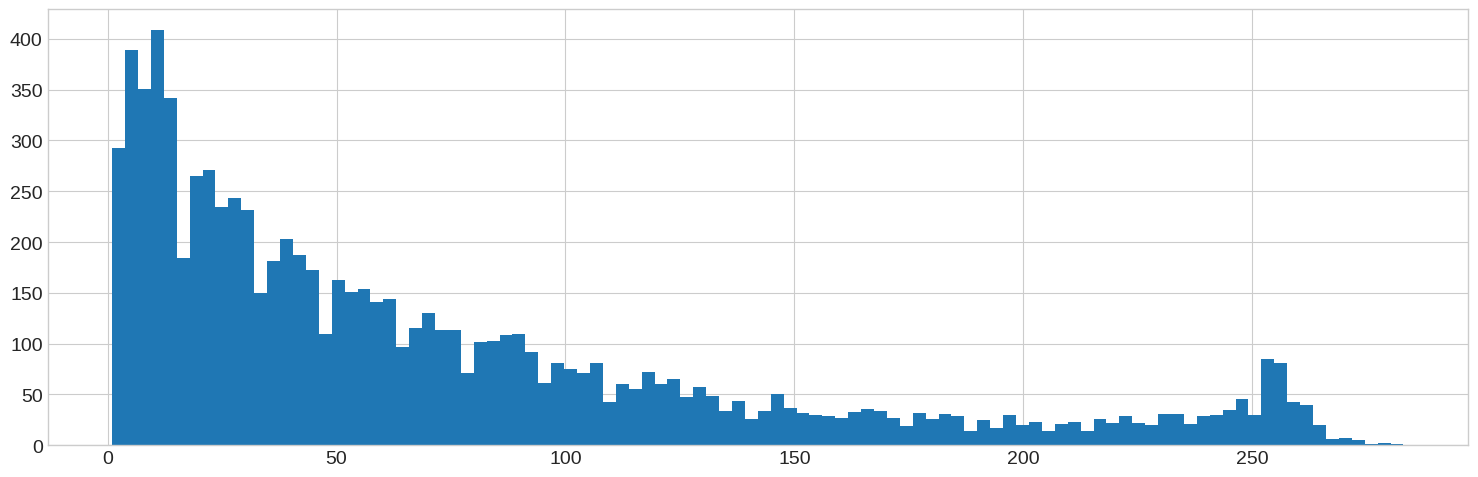

In [ ]:
print(np.mean(data.text.str.len()), data.text.str.len().max())
# print % under 128 and 256
data.text.str.len().hist(bins = 100);

Зададим модель, токенизатор, функцию потерь, кол-во батчей и макс. длину.

In [ ]:
model_roberta_l,  = 'ai-forever/ruRoberta-large',
tokenizer = RobertaTokenizer.from_pretrained(model_roberta_l)

MAX_LEN = 128

def loss_fn(outputs, targets):
    return nn.BCELoss()(outputs, targets)

BATCH_SIZE = 16
print(f'Размер батча: {BATCH_SIZE}')

vocab.json:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

Размер батча: 16


#### Датасет.

`_bo` - текст, ординальный и бинарные признаки отдельно.

In [ ]:
params_bo = dict(
    binary_names = ['payment', 'price', 'delivery', 'promotions',
                    'products_quality', 'assortment', 'support',
                    'catalog_navigation'],
    ordinal_names = ['assessment'],
    label_names = [f'trend_id_res{i}' for i in range(50)],
    tokenizer = tokenizer,
    max_len = MAX_LEN
)

num_ordinal_features_bo = len(params_bo['ordinal_names'])
num_binary_features_bo = len(params_bo['binary_names'])

train_dataset_bo = MixedInputDataset(train, **params_bo)
val_dataset_bo = MixedInputDataset(val, **params_bo)
test_dataset_bo = MixedInputDataset(test, **params_bo)

train_data_loader_bo = DataLoader(
    train_dataset_bo,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_data_loader_bo = DataLoader(
    val_dataset_bo,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

test_data_loader_bo = DataLoader(
    test_dataset_bo,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

In [ ]:
next(iter(train_dataset_bo))

{'text': 'Последние разы привозили гнилые овощи, что было видно невооруженным глазом. В поддержке отвечают скриптами. Никакого уважения к клиенту',
 'input_ids': tensor([    1, 39618, 36648, 21844,   489, 22507,   527, 24585,    16,   368,
           556,  3641,  1040, 32829,  1760, 14629,    18,   378, 15292, 29321,
          7013, 22527,    18, 26537, 17384,   294, 49930,     2,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0

##### experiments with model class

#### Класс модели с опциональным смешанным входом.

In [ ]:
class MixedInputModel(nn.Module):
    def __init__(self,
                 num_ordinal_features: int = None,
                 num_binary_features: int = None,
                 ordinal_layer_dim = 8,
                 binary_layer_dim = 8,
                 num_labels: int = 50,
                 model_name: str = 'ai-forever/ruRoberta-large',
                 dropout : float = None,
                 pooler_output : bool = False):

        super(MixedInputModel, self).__init__()

        # roberta no cls head
        self.roberta = RobertaModel.from_pretrained(model_name)

        # pooled_out
        self.pooler_output = pooler_output
        # dropout
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = None

        # ordinal proc
        self.ordinal_fc = nn.Linear(num_ordinal_features, ordinal_layer_dim)

        # binary proc
        self.binary_fc = nn.Linear(num_binary_features, binary_layer_dim)

        # combined
        input_size = self.roberta.config.hidden_size
        if num_ordinal_features is not None:
            input_size += ordinal_layer_dim
        if num_binary_features is not None:
            input_size += binary_layer_dim

        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, num_labels)

    def forward(self,
                text_input,
                attention_mask,
                ordinal_input = None,
                binary_input = None):

        # text proc roberta
        outputs = self.roberta(input_ids = text_input,
                               attention_mask = attention_mask)
        if self.pooler_output:
            text_out = outputs.pooler_output
        else:
            text_out = outputs.last_hidden_state[:, 0, :]
        combined = [text_out]

        # ordinal and binary proc if any
        if ordinal_input is not None:
            # print(f"Ordinal input shape: {ordinal_input.shape}")
            ordinal_out = self.ordinal_fc(ordinal_input)  # (batch_size, 64)
            combined.append(ordinal_out)
            # print(f"Ordinal output shape: {ordinal_out.shape}")
        else:
            ordinal_out = None

        if binary_input is not None:
            binary_out = self.binary_fc(binary_input)  # (batch_size, 32)
            combined.append(binary_out)
            # print(f"Binary output shape: {binary_out.shape}")
        else:
            binary_out = None

        # concat
        combined = torch.cat(combined, dim=1)  # (batch_size, 864)
        # print(f"Combined shape before fc layers: {combined.shape}")

        # fc layers
        if self.dropout is not None:
            x = self.dropout(torch.relu(self.fc1(combined)))
        else:
            x = torch.relu(self.fc1(combined))  #  (batch_size, 256)
        output = torch.sigmoid(self.fc2(x))  # multi-label

        return output

In [ ]:
def train_model(
        model: nn.Module,
        train_loader: torch.utils.data.dataloader.DataLoader,
        val_loader: torch.utils.data.dataloader.DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: callable,
        num_epochs: int,
        threshold : float = .5,
        num_ordinal_features: int = None,
        num_binary_features: int = None,
        patience_stop : int = 0,
        patience_lr : int = None,
        device: any = DEVICE,
        model_save_path : str = None,
        model_name : str = None):

    # model.to(device)
    # if torch.cuda.device_count() > 1:
    #     model = nn.DataParallel(model)

    if patience_lr is not None:
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1,
                                      patience=patience_lr, cooldown=2)
    patience_counter = 0

    best_val_loss = float('inf')
    history = {}
    history['train_loss'] = []
    history['val_loss'] = []
    history['train_accuracy'] = []
    history['val_accuracy'] = []


    for epoch in trange(num_epochs):
        # train
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        for batch in train_loader:
            text_input = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            if 'ordinal' in batch:
                ordinal_input = batch['ordinal'].to(device).view(-1, num_ordinal_features)
            else:
                ordinal_input = None
            if 'binary' in batch:
                binary_input = batch['binary'].to(device).view(-1, num_binary_features)
            else:
                binary_input = None
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            # forward
            outputs = model(text_input, attention_mask,
                            ordinal_input, binary_input)

            # loss
            loss = loss_fn(outputs, labels)
            train_loss += loss.item()

            # backward
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            # get preds for metric
            predicted = (outputs > threshold).float()
            batch_correct = (
                (predicted.cpu().numpy() == labels.cpu().numpy())
                .all(axis=1)
                .sum()
                )
            train_correct += batch_correct
            total_train += labels.size(0)

        # metrics
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / total_train

        # validation
        model.eval()
        val_correct = 0
        total_val = 0
        val_loss = 0.0
        all_val_labels = []
        all_val_preds = []

        with torch.no_grad():
            for batch in val_loader:
                text_input = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                if 'ordinal' in batch:
                    ordinal_input = (batch['ordinal']
                                     .to(device)
                                     .view(-1, num_ordinal_features))
                else:
                    ordinal_input = None
                if 'binary' in batch:
                    binary_input = (batch['binary']
                                    .to(device)
                                    .view(-1, num_binary_features))
                else:
                    binary_input = None
                labels = batch['labels'].to(device)

                # forward
                outputs = model(text_input, attention_mask,
                                ordinal_input, binary_input)

                # loss
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                # get preds for metric
                predicted = (outputs > 0.5).float()
                batch_correct = (
                    predicted.cpu().numpy() == labels.cpu().numpy()
                    ).all(axis=1).sum()
                val_correct += batch_correct
                total_val += labels.size(0)

        val_accuracy = val_correct / total_val

        avg_val_loss = val_loss / len(val_loader)
        print(f'Epoch [{epoch + 1}/{num_epochs}], ' +
              f'Train Loss: {avg_train_loss:.4f}, '+
              f'Train Accuracy: {train_accuracy:.4f}, '+
              f'Val Loss: {avg_val_loss:.4f}, '+
              f'Val Accuracy: {val_accuracy:.4f}')

        history['train_accuracy'].append(train_accuracy)
        history['train_loss'].append(train_loss)
        history['val_accuracy'].append(val_accuracy)
        history['val_loss'].append(val_loss)

        if patience_lr is not None:
            scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(),
                       os.path.join(model_save_path, model_name))
        else:
            patience_counter += 1

        if patience_stop != 0 and patience_counter >= patience_stop:
            print('Ранний останов из-за переобучения.')
            print(f'Лучшее значение потери на валидации: {best_val_loss}')
            print(f'Текущее значение потери на валидации: {avg_val_loss}')
            break

    return model, history

In [ ]:
if env == 'kaggle':
    SAVE_PATH = '/kaggle/working/'
elif env == 'colab':
    SAVE_PATH = ('/content/drive/Othercomputers/PC/JupiterNB/Yandex_'+
                 'Practicum_Workshop/NLP_Multilabel_Samokat/')
elif env == 'local':
    SAVE_PATH = ''

In [ ]:
model_mnn_bo = MixedInputModel(
    num_ordinal_features = num_ordinal_features_bo,
    num_binary_features = num_binary_features_bo
    ).to(DEVICE)

optimizer = AdamW(model_mnn_bo.parameters(), lr = 1e-5)
NUM_EPOCHS = 100

train_params_bo = dict(
    model = model_mnn_bo,
    train_loader = train_data_loader_bo,
    val_loader = val_data_loader_bo,
    optimizer = optimizer,
    loss_fn = loss_fn,
    num_epochs = NUM_EPOCHS,
    num_ordinal_features = num_ordinal_features_bo,
    num_binary_features = num_binary_features_bo,
    model_save_path = SAVE_PATH,
    model_name = 'model_mnn_bo.pth'
)

model, history = train_model(**train_params_bo)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.3551, Train Accuracy: 0.0007, Val Loss: 0.2176, Val Accuracy: 0.0000
Epoch [2/100], Train Loss: 0.1714, Train Accuracy: 0.0000, Val Loss: 0.1348, Val Accuracy: 0.0000
Epoch [3/100], Train Loss: 0.1207, Train Accuracy: 0.0105, Val Loss: 0.1029, Val Accuracy: 0.0780
Epoch [4/100], Train Loss: 0.0953, Train Accuracy: 0.1132, Val Loss: 0.0856, Val Accuracy: 0.2254
Epoch [5/100], Train Loss: 0.0795, Train Accuracy: 0.2325, Val Loss: 0.0757, Val Accuracy: 0.2719
Epoch [6/100], Train Loss: 0.0674, Train Accuracy: 0.3630, Val Loss: 0.0686, Val Accuracy: 0.3684
Epoch [7/100], Train Loss: 0.0582, Train Accuracy: 0.4555, Val Loss: 0.0645, Val Accuracy: 0.4063
Epoch [8/100], Train Loss: 0.0508, Train Accuracy: 0.5152, Val Loss: 0.0603, Val Accuracy: 0.4312
Epoch [9/100], Train Loss: 0.0441, Train Accuracy: 0.5727, Val Loss: 0.0579, Val Accuracy: 0.4355
Epoch [10/100], Train Loss: 0.0383, Train Accuracy: 0.6179, Val Loss: 0.0565, Val Accuracy: 0.4724
Epoch [11/100], Tra

## Вывод.

- Нейросеть требует более детальной проработки и экспериментов с добалвнием тэгов и/или оценок в текст и др.